# RL PRACTICE ➡️ Pig Dice Game | Pass the Pigs (`numba`version)

<div class="alert alert-info">
<h2>Objective</h2>
<p>Find and optimal policy for playing the game (in either of the possible variants: <code>GAME_PIG_DICE</code> or <code>GAME_PASS_THE_PIGS</code>)  using a RL Dynamic Programming algorithm</p>  
<p>You can choose either a <code>Policy Iteration & Improvement</code> algorithm or a<code>Value Iteration</code> algorithm</p>  
<p>Review the general documentation included in the assingment description for obtaining a general inutition of the mechanics of the game</p>  
<h2>Notes</h2>
<p>🟨 For guiding and helping you in understanding the types of <b>representations</b> (states, actions, policies) used and the <b>system dynamics</b> of the environment you are provided with some code for examples of policies [Policy helpers (opponent's policies)] and for the transitioning rules of the game [Basic simplified environment ➡️ As numba functions]</p>  
<p>🟨 You will not need such functions but, however, you might just need to include (copy) pieces of this code into your final algorithm for implementing the sweeps of state/action/state transitions in your algorithm</p>
<p>🟨 Additionally, you are provided with a basic example for the visualization of the resulting policies [Utility and plotting functions]. You may use those or either implement other specific tools/plots that you consider more convenient for the visualization, interpretation or explanation of the policies obtained</p>  
<p>🟨 The code is adapted for <code>numba</code> for faster execution, but in this case you can implement your algorithms practically with no change from standard python syntax. In the case, that you find difficulties or error that make the debugging process more complicated, just comment out the <code>@njit</code> decorators</p>
<hr>
<strong>
Review the notebook and fill in the missing code appropriately.<br>
Check the final executability and results of the resulting code.
</strong></div>

## Imports and variables

In [1]:
# Setup
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [86]:
# ------------------------------------------------------------
# Two-player Pig (current-player view), Dynamic Programming (value iteration)
# and Q-learning via self-play. Compares vs "hold at 25" heuristic.
# Produces 3D policy plots for each policy.

# from __future__ import annotations
import math, random, time
from collections import defaultdict
import typing
from typing import Dict, Tuple, Literal

import numpy as np
import pickle

import numba
from numba import njit, typed, types # jit, prange, objmode
from numba import int32, float32    # import the basic types for numba specs
from numba.experimental import jitclass
# from numba.typed import Dict, List
"""
https://numba.readthedocs.io/en/stable/index.html
In @njit(nopython=True) functions, globals are treated as compile-time constants. 
You can read certain globals, but you generally cannot rebind them, and many Python containers are not supported.
⚠️ You may be able to mutate the contents of a global NumPy array inside @njit, but you cannot reassign the global name. 
It’s safer and clearer to pass arrays (or typed.Dict) as arguments (passed by reference)
"""
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib widget

# -----------------------------
# Global configuration
# -----------------------------
GAMMA = 0.99         # almost undiscounted episodic game
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
RNG = random.Random(SEED)  # reproducible; change/seed as you like

# ----------------------------
# Game configuration
# ----------------------------
GOAL = 100
ROLL, HOLD = 0, 1
ACTIONS = (ROLL, HOLD)

GAME_PIG_DICE      = 0
GAME_PASS_THE_PIGS = 1
GAME = GAME_PASS_THE_PIGS
GAME = GAME_PIG_DICE

if GAME == GAME_PIG_DICE:
    DIE_SIDES = 6
    PIG_OUT  = 1
    outcomes = tuple(range(1,DIE_SIDES+1))
    out_prob = tuple([1.0/DIE_SIDES]*DIE_SIDES)
elif GAME == GAME_PASS_THE_PIGS:
    # OUTS      = ('PIG_OUT','PIGGYBACK','OINKER')
    PIGGYBACK = -2
    OINKER    = -1
    PIG_OUT   = 0
    # abridged system dynamics
    outcomes = (PIGGYBACK, OINKER, PIG_OUT, 1, 5, 10, 15, 20, 25, 40, 60)
    out_prob = (0.001, 0.0386, 0.1922, 0.1922, 0.31, 0.1168, 0.0846, 0.0525, 0.0056, 0.0049, 0.0016)

# If True, a player wins immediately if their *running* score (score+turn_total) reaches GOAL during the turn (without needing to hold). 
# If False, they must hold to bank.
INSTANT_WIN_ON_ROLL = True    

# ----------------------------
# RL Definitions
# ----------------------------
State  = Tuple[int, int, int]  # (me, opp, turn) # always from the point of view of Player A (me)
Bucket = Tuple[int, int, int]  # (me, opp, turn)
Policy  = np.ndarray # Dict[Tuple[int,int,int], int or float] # the "float" case is just for being able of holding np.nan (for some better 3d plots)
QValues = np.ndarray # Dict[Tuple[int,int,int], list of floats]

BUCKET = 10 # Points (for grouping scores into buckets)
MAX_BUCKETS = GOAL//BUCKET

## Policy helpers (opponent's policies)

In [87]:
# policy_roller() can be built as policy_hold_at_(GOAL)    
# policy_random() can be built as policy_hold_at_(randomize=True)    
def policy_hold_at_(threshold=25, randomize=False) -> np.ndarray: # Dict[State, Action]
    """Heuristic policy: hold if turn >= 25; always hold if can immediately win."""
    # P: Dict[State, int] = {}
    P = np.ones((GOAL,GOAL,GOAL),dtype=float)*HOLD # *np.nan # default is HOLD
    for me in range(GOAL):
        for opp in range(GOAL):
            max_turn = GOAL - 1 - me
            for turn in range(max_turn + 1):
                if me + turn >= GOAL:
                    P[(me, opp, turn)] = HOLD
                else:
                    if randomize:
                        P[(me, opp, turn)] = HOLD if turn >= random.randint(0,GOAL) else ROLL
                        # or alternatively...
                        # P[(me, opp, turn)] = HOLD if random.random() >= 0.5 else ROLL 
                    else:
                        P[(me, opp, turn)] = HOLD if turn >= threshold else ROLL
    return P

## Basic simplified environment ➡️ As `numba` functions

In [88]:
# -----------------------------
# Environment (current-player view)
# -----------------------------
@njit(fastmath=True)
def choice_weighted_idx(prob):
    # prob: 1D array of non-negative weights (need not sum to 1)
    L = len(prob)
    total = 0.0
    for i in range(L): total += prob[i]
    u = np.random.random() * total
    c = 0.0
    for i in range(L):
        c += prob[i]
        if u < c: return i
    return L - 1  # guard for rounding
    
@njit(fastmath=True)
def reset() -> Tuple[State, typing.Dict[str,int]]:
    return (0, 0, 0), {}

@njit(fastmath=True)
def step_1(s: State, a: int) -> Tuple[State, int, bool, bool, typing.Dict[str,int]]:
    """
    One environment step from state s using action a.
    Returns (next_state, reward, terminated, truncated, info) --> truncated means swap turns

    Reward is from the perspective of the *actor* at s:
    +1 if the actor wins, -1 if the actor loses, else 0.
    """
    me, opp, turn = s

    # Terminal guard (shouldn't be called on terminal states)
    if me >= GOAL:
        print('ERROR! Attempting a terminal state')   
        return s, +1, True, False, {'swap':0}
    if opp >= GOAL:
        print('ERROR! Attempting a terminal state')   
        return s, -1, True, False, {'swap':0}

    if a == HOLD:
        # Bank turn; if enough to win -> terminal +1
        if me + turn >= GOAL:
            return (me + turn, opp, 0), +1, True, False, {'swap':0}
        # Otherwise pass turn: roles swap => next current player is the (previous) opponent
        return (opp, me + turn, 0), 0, False, True, {'swap':1}
    
    # +-------------------------------------+
    # |         System Dynamics             |
    # +-------------------------------------+
    # a == "roll"
    if GAME == GAME_PIG_DICE:
        # d = random.randint(1, DIE_SIDES)
        # d = np.random.choice(outcomes, 1, p=out_prob)[0]
        # d = random.choices(outcomes, weights=out_prob, k=1)[0]
        d = outcomes[choice_weighted_idx(out_prob)]
        if d == PIG_OUT:
            # Pig out: lose running total, pass turn (roles swap)
            return (opp, me, 0), 0, False, True, {'swap':1}
        if me + turn + d >= GOAL:
            return (me + turn + d, opp, 0), +1, True, False, {'swap':0}
        return (me, opp, turn + d), 0, False, False, {'swap':0}
    elif GAME == GAME_PASS_THE_PIGS:    
        # abridged system dynamics
        # outcomes = [PIGGYBACK, OINKER, PIG_OUT, 1, 5, 10, 15, 20, 25, 40, 60]
        # out_prob = [0.001, 0.0386, 0.1922, 0.1922, 0.31, 0.1168, 0.0846, 0.0525, 0.0056, 0.0049, 0.0016]
        # d = np.random.choice(outcomes, 1, p=out_prob)[0]    
        d = outcomes[choice_weighted_idx(out_prob)]
        if d == PIGGYBACK: # Player is eliminated  (roles swap)
            return (opp, 0, 0), -1, True, False, {'swap':0}
        elif d == OINKER: # (Back to Zero) Player's total score from the game is wiped out
            return (opp, 0, 0), 0, False, True, {'swap':1}
        elif d == PIG_OUT: # Pigs lie on opposite sides --> Player's score for the turn is wiped out
            # Pig out: lose running total, pass turn (roles swap)
            return (opp, me, 0), 0, False, True, {'swap':1}
        elif me + turn + d >= GOAL:
            return (me + turn + d, opp, 0), +1, True, False, {'swap':0}
        else:
            return (me, opp, turn + d), 0, False, False, {'swap':0}
    print('ERROR! Undefined step return')   
    return (0, 0, 0), 0, False, False, {'swap':0}

# example...
step_1((0,1,2), HOLD)            

((1, 2, 0), 0, False, True, DictType[unicode_type,int64]<iv=None>({swap: 1}))

## Utility and plotting functions

In [89]:
def policy_to_array_expanded(policy,goal=GOAL):
    """Expands a "bucketed" policy and "clears" unreachable states"""
    if policy.shape[0] == goal:
        policy_arr = policy.astype(float)
    else:
        bucket_size, remainder = divmod(goal, policy.shape[0])
        if remainder != 0:
            raise Exception(f"{policy.shape[0]} not exactly expandable to {goal}")
        else:
            policy_arr = policy.repeat(bucket_size, axis=0).repeat(bucket_size, axis=1).repeat(bucket_size, axis=2).astype(float)
            # Alternative one-liner with np.kron:
            # policy_arr = np.kron(policy, np.ones((bucket_size, bucket_size, bucket_size), dtype=policy.dtype))
    for me in range(goal):
        for opp in range(goal):
            max_turn = goal - 1 - me
            for turn in range(goal):
                if me + turn >= goal:
                    policy_arr[me,opp,turn] = np.nan
    return policy_arr

def policy_to_array_compressed(policy,bucket_size=10):
    """Compress a policy into a "bucketed" policy"""
    buckets = GOAL//bucket_size
    # A = np.random.randn(15, 15, 15)  # your array
    # Average each 3×3×3 block → (5,5,5)
    B_float = policy.reshape(buckets, bucket_size, 
                        buckets, bucket_size, 
                        buckets, bucket_size).mean(axis=(1, 3, 5))
    
    # Convert averages to integers (round-to-nearest)
    B = np.rint(B_float).astype(int)
    return B


# --- Compute threshold surface t*(a,b): minimal t where HOLD is optimal
def threshold_surface(policy):
    policy_no_nan = np.nan_to_num(policy, nan=HOLD)
    thr = np.zeros((GOAL, GOAL), dtype=np.int32)
    for a in range(GOAL):
        for b in range(GOAL):
            hold_ts = np.where(policy_no_nan[a, b, :] == HOLD)[0]
            thr[a, b] = hold_ts[0] if hold_ts.size > 0 else GOAL - 1
    return thr

def plot_surface(thr, name):
    # --- 3D plot (waterfall/wireframe style) ---
    fig = plt.figure(figsize=(8, 6), facecolor="white")
    ax = fig.add_subplot(111, projection="3d")
    
    # Axes ranges
    ax.set_xlim(0, GOAL - 1)
    ax.set_ylim(0, GOAL - 1)
    ax.set_zlim(0, GOAL - 1)
    
    # Labels
    ax.set_xlabel("player score a")
    ax.set_ylabel("opponent score b")
    ax.set_zlabel("minimal t* to HOLD")
    
    # View
    ax.view_init(elev=28, azim=-55)
    
    # Style the panes/grid to be light
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis._axinfo["grid"]['color'] = (0.7, 0.7, 0.7, 0.8)
    ax.xaxis.pane.set_facecolor((1, 1, 1, 0.0))
    ax.yaxis.pane.set_facecolor((1, 1, 1, 0.0))
    ax.zaxis.pane.set_facecolor((1, 1, 1, 0.0))
    
    # Waterfall lines for each opponent score b (colored by b)
    # import matplotlib.cm as cm
    # cmap = cm.get_cmap("viridis")
    # The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. 
    # Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
    cmap = plt.get_cmap("viridis")
    # cmap = mpl.colormaps.get_cmap('viridis') # Use the 'viridis' colormap
    cmap.set_bad(color='red') # Set NaN values to red
    
    a = np.arange(GOAL)
    for b in range(GOAL):
        z = thr[a, b]
        color = cmap(b / (GOAL - 1))
        ax.plot(a, np.full_like(a, b), z, color=color, linewidth=1.0, alpha=0.95)
    """
    # Overlay the "bank-to-win" surface t_win(a) = GOAL - a
    # Draw it as many vertical curtains (one per b) to resemble a slanted plane.
    twin = (GOAL - 1) - a  # stays within zlim (0..GOAL-1)
    for b in range(0, GOAL, 2):
        ax.plot(a, np.full_like(a, b), twin, color=cmap(1.0), linewidth=1.2, alpha=0.6)
    """
    plt.tight_layout()
    if name:
        out_path = f"data/threshold_surface_3d_{name}.png"
        plt.savefig(out_path, dpi=140, transparent=True)
        print(f"Saved 3D plot to: {out_path}")
    plt.show()


def save_array(arr,filename="file_no_name"):
    # Save the array to a file using Pickle
    with open(filename+'.pkl', 'wb') as file:
        pickle.dump(arr, file)
    return arr  

def load_array(filename):
    # Load the array back from the file
    with open(filename+'.pkl', 'rb') as file:
        arr = pickle.load(file)
    return arr

In [90]:
import os
# os.makedirs with exist_ok=True will not raise an error if the folder exists
os.makedirs('data', exist_ok=True)

## Heuristic policies Policy Visualization

Saved 3D plot to: data/threshold_surface_3d_hold_at_25.png


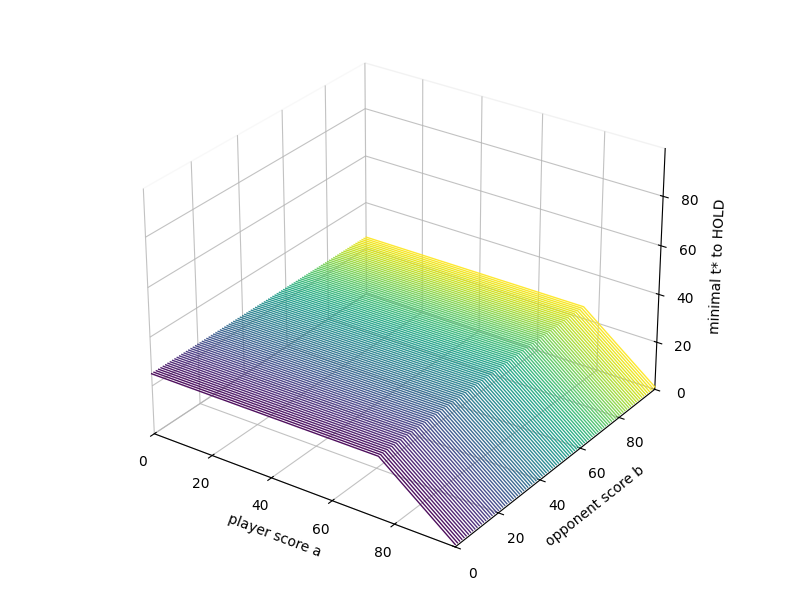

In [91]:
if True:
    policy_h25 = policy_hold_at_(25)
    
    policy_h25_a = policy_to_array_expanded(policy_h25)
    thr = threshold_surface(policy_h25_a)
    plot_surface(thr,'hold_at_25')    

# Assignment

## Dynamic Programming
**Choose and implement one algorithm**
* Policy Iteration and Improvement
* Value Iteration

Game: Game_Pig_Dice

**VALUE ITERATION**

Algorithm choice: 

Value Iteration over Policy Iteration because it converges in a single loop without an inner evaluation loop, making it more efficient for this 100x100x100 state space.


State Representation:

The game state is represented as (me, opp, turn), always from the perspective of the player currently acting. This "current-player view" simplifies the Bellman equations since we only need one value function V instead of two (one per player).

  me   : total score of the player currently rolling

  opp  : total score of the opponent

  turn : points accumulated in the current turn 

Value function: 

V[me, opp, turn] represents the expected discounted return for the current player (+1 = win and -1 = loss)

Since the game is zero-sum, when the turn passes to the opponent, the new current player's
gain is our loss (negamax formulation): V_for_me = GAMMA * ( -V[opp, my_new_score, 0] )

The Bellman optimality equation then becomes:

  V(me, opp, turn) = max(
      GAMMA * (-V[opp, me+turn, 0]),             
      sum_d p(d) * GAMMA * V(me, opp, turn+d)     
  )

Value Iteration applies this update repeatedly across all states until the maximum change (delta) falls below threshold theta, guaranteeing convergence to the optimal value function and policy.


In [104]:
# @jit(nopython=True)
# @njit  # or: @njit(inline='always')
@njit(parallel=True, fastmath=True)
def value_iteration(theta: float = 1e-9, max_iters: int = 2_000, verbose: bool = True):
    """
    Value iteration in current-player view
    Returns: (V, policy) where V is a defaultdict(float), policy is Dict[State, Action].
    Note: For GOAL=100, this is exact but may take some time to converge.
    """
    # Allocate values & policy
    V = np.zeros((GOAL, GOAL, GOAL), dtype=np.float64)
    policy = np.zeros((GOAL, GOAL, GOAL), dtype=np.uint8)
    
    # Initialise terminal states: holding wins immediately when me + turn >= GOAL
    for me in range(GOAL):
        for opp in range(GOAL):
            for turn in range(GOAL - me, GOAL):
                V[me, opp, turn]      = 1.0
                policy[me, opp, turn] = HOLD

    n_out = len(outcomes)

    for iteration in range(max_iters):
        delta = 0.0

        for me in range(GOAL):
            for opp in range(GOAL):
                for turn in range(GOAL - me):  

                    # HOLD: pass turn to opponent (zero-sum)
                    v_hold = GAMMA * (-V[opp, me + turn, 0])

                    # ROLL: 
                    v_roll = 0.0
                    for i in range(n_out):
                        d = outcomes[i]
                        p = out_prob[i]
                        
                        if d == PIG_OUT:
                            v_roll += p * GAMMA * (-V[opp, me, 0])
                        elif me + turn + d >= GOAL:
                            v_roll += p * 1.0
                        else:
                            v_roll += p * GAMMA * V[me, opp, turn + d]

                    # Bellman optimality update
                    new_v = v_hold if v_hold >= v_roll else v_roll
                    d_curr = new_v - V[me, opp, turn]
                    if d_curr < 0.0:
                        d_curr = -d_curr
                    if d_curr > delta:
                        delta = d_curr
                    V[me, opp, turn]      = new_v
                    policy[me, opp, turn] = HOLD if v_hold >= v_roll else ROLL

        if verbose and (iteration % 100 == 0):
            print('iteration:', iteration, ' delta:', delta)
        if delta < theta:
            if verbose:
                print('Converged at iteration:', iteration + 1, ' delta:', delta)
            break

    return V, policy

## Dynamic Programming (Value Iteration)

=== Dynamic Programming (Value Iteration) ===
iteration: 0  delta: 0.8333333333333333
iteration: 100  delta: 0.0003561583209041319
Converged at iteration: 187  delta: 9.428536640321283e-07
time: 0.5170927047729492
Saved 3D plot to: data/threshold_surface_3d_dyn_prog_game-0.png


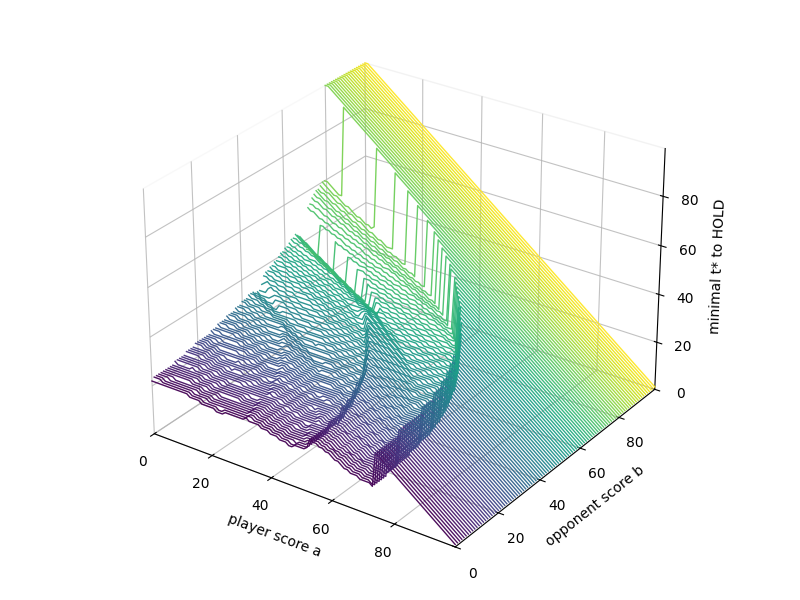

In [105]:
if True: # execute only when desired...
    THETA = 1e-6
    print("=== Dynamic Programming (Value Iteration) ===")
    _start = time.time()
    V_dp, policy_dp = value_iteration(theta=THETA, max_iters=1_200, verbose=True)
    #or...
    #V_dp, policy_dp = policy_iteration(theta=THETA, max_iters=1_200, verbose=True)
    print('time:',time.time()-_start)

    save_array(V_dp, filename=f"data/values_dyn_prog_game-{GAME}")
    save_array(policy_dp, filename=f"data/policy_dyn_prog_game-{GAME}")
    
    policy_dp_a = policy_to_array_expanded(policy_dp)
    thr = threshold_surface(policy_dp_a)
    plot_surface(thr,f'dyn_prog_game-{GAME}')

In [94]:
# Check threshold for some balanced midgame positions
for me in [20, 40, 50, 60]:
    for opp in [20, 40, 50, 60]:
        thr_val = thr[me, opp]
        print(f"me = {me}, opp = {opp} - hold at turn = {thr_val}")

me = 20, opp = 20 - hold at turn = 23
me = 20, opp = 40 - hold at turn = 26
me = 20, opp = 50 - hold at turn = 30
me = 20, opp = 60 - hold at turn = 33
me = 40, opp = 20 - hold at turn = 19
me = 40, opp = 40 - hold at turn = 22
me = 40, opp = 50 - hold at turn = 27
me = 40, opp = 60 - hold at turn = 26
me = 50, opp = 20 - hold at turn = 18
me = 50, opp = 40 - hold at turn = 22
me = 50, opp = 50 - hold at turn = 20
me = 50, opp = 60 - hold at turn = 23
me = 60, opp = 20 - hold at turn = 17
me = 60, opp = 40 - hold at turn = 16
me = 60, opp = 50 - hold at turn = 17
me = 60, opp = 60 - hold at turn = 40


The surface shows the minimal turn accumulation needed before holding. 

When player score is high (close to 100), the threshold drops — hold early to avoid risking a pig-out. 

When the opponent is far ahead, the threshold rises — roll more aggressively to catch up

For balanced midgame positions, the threshold clusters around 20-25

In [95]:
# Simulate N games: DP policy vs hold-at-25 heuristic
def simulate_win_rate(policy_A, policy_B, n_games=50_000):
    wins_A = 0
    for _ in range(n_games):
        me, opp, turn = 0, 0, 0
        current = 'A'
        while True:
            if current == 'A':
                a = int(policy_A[me, opp, turn])
            else:
                a = int(policy_B[opp, me, turn])  

            s, r, terminated, truncated, _ = step_1((me, opp, turn), a)
            me, opp, turn = s

            if terminated:
                if current == 'A' and r == 1: wins_A += 1
                if current == 'B' and r == 1: pass  
                break
            if truncated:
                me, opp, turn = opp, me, turn  
                current = 'B' if current == 'A' else 'A'

    return wins_A / n_games

wr = simulate_win_rate(policy_dp, policy_h25)
print(f"DP policy wins {wr*100:.1f}% of games vs hold-at-25")
print(f"hold-at-25 wins {(1-wr)*100:.1f}% of games vs DP policy")

DP policy wins 52.7% of games vs hold-at-25
hold-at-25 wins 47.3% of games vs DP policy


The DP policy wins around 52.7% of games vs hold-at-25, confirming the optimal policy is strictly better than the heuristic. A random play would give 50%, the extra 2.7% reflects the benefit of context-aware decisions by adjusting the hold threshold based on both players' scores.

The gap is not larger because GAMMA=0.99 slightly biases towards winning faster rather than maximising pure win probability.